In [1]:
%load_ext autoreload
%autoreload 2

from pxr import Usd, UsdGeom
from matplotlib import pyplot as plt
from torch import Tensor

from scripts.view_animation_usd import apply_transform_homogeneous
from text3d2video.ipython_utils import view_pointcloud_orthographic

# Load USD file
usd_file = '/home/jorge/untitled.usdc'
stage = Usd.Stage.Open(usd_file)

/home/jorge/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jorge/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
for prim in stage.Traverse():
    print(prim.GetPath())

/root
/root/Armature
/root/Armature/Ch36
/root/Armature/Ch36/Mesh
/root/Camera
/root/Camera/Camera


In [3]:
frame_start = int(stage.GetStartTimeCode())
frame_end = int(stage.GetEndTimeCode())

frame = frame_start
xform_cache = UsdGeom.XformCache(time=frame)

In [4]:
for prim in stage.Traverse():
    if prim.IsA(UsdGeom.Mesh):
        mesh = UsdGeom.Mesh(prim)
    if prim.IsA(UsdGeom.Camera):
        camera = UsdGeom.Camera(prim)

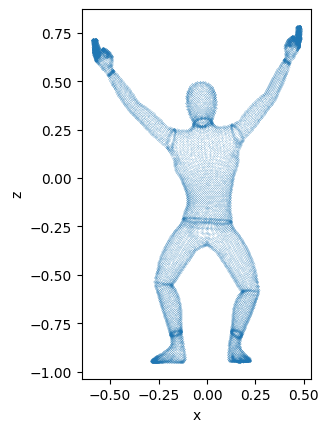

In [5]:
m2w = xform_cache.GetLocalToWorldTransform(mesh.GetPrim())
m2w = Tensor(m2w).T

verts = mesh.GetPointsAttr().Get()
face_indices = Tensor(mesh.GetFaceVertexIndicesAttr().Get()).int()
face_count = Tensor(mesh.GetFaceVertexCountsAttr().Get()).int()

verts = Tensor(mesh.GetPointsAttr().Get(frame))
verts_world = apply_transform_homogeneous(verts, m2w)

fig, ax = plt.subplots()
view_pointcloud_orthographic(ax, verts_world, horizontal_dim=0, vertical_dim=2)

In [6]:
from text3d2video.coord_utils import BLENDER_WORLD_TO_PT3D_WORLD

verts_world_pt3d = verts_world @ BLENDER_WORLD_TO_PT3D_WORLD.T

In [7]:
from pytorch3d.structures import Meshes

from text3d2video.usd_utils import triangulate_usd_mesh

triangle_indices = triangulate_usd_mesh(face_count, face_indices)
mesh_pt3d = Meshes(verts=[verts_world_pt3d], faces=[triangle_indices])

In [8]:
from scripts.view_animation_usd import decompose_transform_srt
from pytorch3d.renderer import FoVPerspectiveCameras

c2w = xform_cache.GetLocalToWorldTransform(camera.GetPrim())
c2w = Tensor(c2w).T

t, _, r = decompose_transform_srt(c2w)

In [9]:
import torch
from scripts.view_animation_usd import assemble_transform_srt
from text3d2video.coord_utils import BLENDER_CAM_TO_PT3D_CAM

rp = BLENDER_WORLD_TO_PT3D_WORLD @ r @ BLENDER_CAM_TO_PT3D_CAM
tp = BLENDER_WORLD_TO_PT3D_WORLD @ t

c2w_pt3d = assemble_transform_srt(tp, torch.ones(3), rp)

In [10]:
w2c_pt3d = c2w_pt3d.inverse()
t_w2c, _, r_w2c = decompose_transform_srt(w2c_pt3d)

cam = FoVPerspectiveCameras(R=r_w2c.T.unsqueeze(0), T=t_w2c.unsqueeze(0), fov=40)

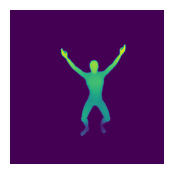

<Figure size 640x480 with 0 Axes>

In [11]:
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

depths = render_depth_map(mesh_pt3d.cuda(), cam.cuda())
display_ims(depths)

In [12]:
from pxr import UsdGeom

uv = mesh.GetPrim().GetProperty("primvars:st").Get()
uv = torch.Tensor(uv)

In [13]:
from text3d2video.usd_utils import usd_uvs_to_pt3d_uvs

verts_uvs_, faces_uvs_ = usd_uvs_to_pt3d_uvs(uv, len(triangle_indices))

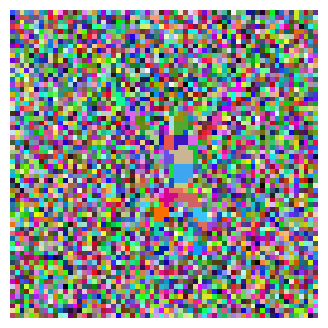

<Figure size 640x480 with 0 Axes>

In [15]:
from text3d2video.uv_noise import prepare_uv_initialized_latents
import torchvision.transforms.functional as TF

gen = torch.Generator(device='cuda')
gen.manual_seed(0)

latents = prepare_uv_initialized_latents(
    mesh_pt3d.cuda(),
    cam.cuda(),
    verts_uvs_,
    faces_uvs_,
    latent_texture_res=10,
    sampling_mode="nearest",
    generator=gen
)

latents_pil = [TF.to_pil_image(latent[0:3].cpu()) for latent in latents]

display_ims(latents_pil, scale=4)